In [29]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
train_df = pd.read_csv('assets/input/train.csv')
test_df = pd.read_csv('assets/input/test.csv')
weather_df = pd.read_csv('assets/input/weather.csv')

In [5]:
weather_df.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [6]:
weather_df.Station.value_counts()

1    1472
2    1472
Name: Station, dtype: int64

In [7]:
np.corrcoef(weather_df[weather_df.Station==1].Tmax.T, weather_df[weather_df.Station==2].Tmax.T)

array([[1.        , 0.98689635],
       [0.98689635, 1.        ]])

In [21]:
precip_inches=weather_df.PrecipTotal
precip_inches = precip_inches.map(lambda s:'0' if 'T' in s else s)
precip_inches = precip_inches.map(lambda s:np.nan if 'M' in s else s)
precip_inches = precip_inches.astype(float)

#impute missing value with value from yesterday
for row in range(len(precip_inches)):
    if np.isnan(precip_inches.iloc[row]):
        precip_inches.iloc[row]=precip_inches.iloc[row-1]

In [23]:
weather_df['PrecipInches']=precip_inches

In [25]:
np.corrcoef(weather_df[weather_df.Station==1].PrecipInches.T, weather_df[weather_df.Station==2].PrecipInches.T)

array([[1.        , 0.66950673],
       [0.66950673, 1.        ]])

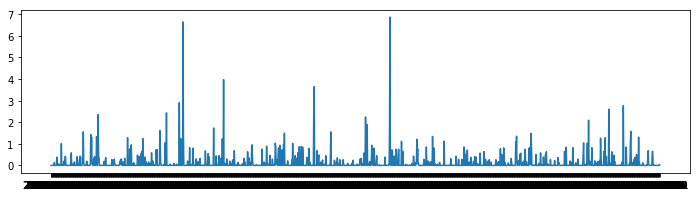

In [31]:
plt.figure(num=1, figsize=(12,3))
plt.plot(weather_df[weather_df.Station==1].Date, weather_df[weather_df.Station==1].PrecipInches)

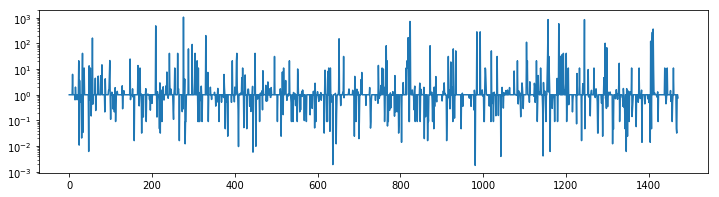

In [52]:
plt.figure(num=2, figsize=(12,3))
plt.plot((weather_df[weather_df.Station==1].PrecipInches.values + 0.001) / (weather_df[weather_df.Station==2].PrecipInches.values  + 0.001))
plt.yscale('log')

In [49]:
np.mean((weather_df[weather_df.Station==1].PrecipInches.values + 0.001) / (weather_df[weather_df.Station==2].PrecipInches.values  + 0.001))

7.317779871409986

In [50]:
np.mean((weather_df[weather_df.Station==2].PrecipInches.values + 0.001) / (weather_df[weather_df.Station==1].PrecipInches.values  + 0.001))

4.245319157887344

In [32]:
from scipy.stats import ttest_rel

In [34]:
t, p = ttest_rel(weather_df[weather_df.Station==1].PrecipInches.T, weather_df[weather_df.Station==2].PrecipInches.T)
print('P value for station 1 precip vs station 2 is {0:.3E}'.format(p))

P value for station 1 precip vs station 2 is 4.337E-01


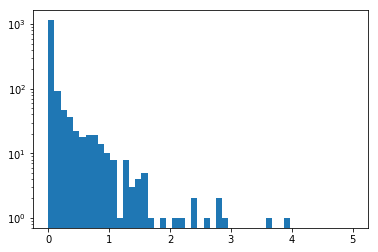

In [56]:
plt.hist(weather_df[weather_df.Station==1].PrecipInches, bins=np.linspace(0,5,50));
plt.yscale('log')

### Functions to calculate time-lagged meteorlogical values

From K Lebl et al, 2013:

Good predictors of c. pipiens/restuans population:
 * Daylight hours 5 weeks ago.  Formula for this in paper
 * Temperature at time of capture
 * Precipitation averaged over last 10 weeks
 * Wind speed averaged over last 3 weeks. This will be 'AverageSpeed', not 'ResultSpeed'

In [155]:
def timelagged_daylight(obs_date):
    """
    Calcuates the hours of daylight 35 days prior to a given date.
    Formula is from Lebl et at, eqn. 1, modified by James Truslow because they screwed 
    up the daylength coefficient.
    
    Parameters
    ----------
    obs_date: a datetime timestamp for the observation
    
    
    Returns
    -------
    Number of daylight hours 35 days prior to 'obs_date'
    """
    
    import datetime as dt
    
    lag_days = 35
    time_lag = dt.timedelta(days=lag_days)
    lagged_date = obs_date - time_lag
    
    # This calculation of day of year will by off by leap years, and maybe an off-by-one for day 0
    day_of_year = (lagged_date.toordinal() - dt.datetime(2007,1,1).toordinal())%365   
    eps = np.arcsin(0.39795 * np.cos(0.2163108 + 2 * np.arctan(0.9671396 * np.tan(0.0086*(day_of_year - 186)))))
    phi = 41.983*2*np.pi/360
    D = 24 - (24/np.pi)*np.arccos((np.sin(0.8333*np.pi/180)+np.sin(phi)*np.sin(eps))/(np.cos(phi)*np.cos(eps)))
    
    #new_df = df.copy()
    #new_df['TimeLaggedDaylight'] = D
    
    return D

In [156]:
def make_timelagged_daylight_col(df):
    new_df = df.copy()
    new_df['TimeLaggedDaylight'] = new_df['dtDate'].map(timelagged_daylight)
    return new_df

In [160]:
new_df = make_timelagged_daylight_col(weather_df)

In [161]:
new_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,PrecipInches,dtDate,TimeLaggedDaylight
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,0.0,2007-05-01,12.376468
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,M,0.00,29.18,29.82,2.7,25,9.6,0.0,2007-05-01,12.376468
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,0.0,2007-05-02,12.423742
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,M,0.00,29.44,30.08,13.3,2,13.4,0.0,2007-05-02,12.423742
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,0.0,2007-05-03,12.470968


In [167]:
def timelagged_temperature(df, obs_date, lag_days_LB=7, lag_days_UB=0):
    """
    Calculates the average temperature in Chicago in some time window before an observation
    
    Parameters
    ----------
    df: dataframe with weather info.  I hope there is date info as datetime objects
    obs_date: a datetime timestamp for the observation
    lag_days_LB: chronological lower bound of time window (inclusive), in number of days *before* observation
    lag_days_UB: chronological upper bound of time window (inclusive), in number of days *before* observation 
    
    Returns
    -------
    Average temperature in time window 
    """
    
    Date_obs = obs_date
    
    time_lag_LB = dt.timedelta(days=lag_days_LB)
    time_lag_UB = dt.timedelta(days=lag_days_UB)
    
    Date_LB = Date_obs - time_lag_LB
    Date_UB = Date_obs - time_lag_UB
    
    window_Tmean = df[(df.dtDate >= Date_LB) & (df.dtDate <= Date_UB)].Tavg.mean()
    
    #new_df = df.copy()
    #new_df['TimeLaggedTemperature'] = window_Tmean
    return window_Tmean

In [162]:
def make_timelagged_temperature_col(df):
    new_df = df.copy()
    new_df['TimeLaggedTemperature'] = df['dtDate'].map(lambda row: timelagged_temperature(df,row))
    return new_df

In [164]:
new_df = make_timelagged_temperature_col(weather_df)

In [165]:
new_df.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,PrecipInches,dtDate,TimeLaggedTemperature
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,0.0,2007-05-01,2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,M,0.00,29.18,29.82,2.7,25,9.6,0.0,2007-05-01,2
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,0.0,2007-05-02,4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,M,0.00,29.44,30.08,13.3,2,13.4,0.0,2007-05-02,4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,0.0,2007-05-03,6


In [168]:
def timelagged_precipitation(df, obs_date, lag_days_LB=70, lag_days_UB=0):
    """
    Calcuates the average precipitation in Chicago in some time window before an observation
    
    Parameters
    ----------
    df: dataframe with weather info.  I hope there is date info as datetime objects
    obs_date: a datetime timestamp for the observation
    lag_days_LB: chronological lower bound of time window (inclusive), in number of days *before* observation
    lag_days_UB: chronological upper bound of time window (inclusive), in number of days *before* observation 
    
    Returns
    -------
    Average precipitation in time window 
    """
    
    Date_obs = obs_date
    
    time_lag_LB = dt.timedelta(days=lag_days_LB)
    time_lag_UB = dt.timedelta(days=lag_days_UB)
    
    Date_LB = Date_obs - time_lag_LB
    Date_UB = Date_obs - time_lag_UB
    
    window_Pmean = df[(df.dtDate >= Date_LB) & (df.dtDate <= Date_UB)].PrecipTotal.mean()
    
    #new_df = df.copy()
    #new_df['TimeLaggedPrecipitation'] = window_Pmean
    return window_Pmean

In [169]:
def make_timelagged_precipitation_col(df):
    new_df = df.copy()
    new_df['TimeLaggedPrecipitation'] = df['dtDate'].map(lambda row: timelagged_precipitation(df,row))
    return new_df

In [170]:
new_df = make_timelagged_precipitation_col(weather_df)

TypeError: Could not convert 0.000.00 to numeric

In [152]:
def timelagged_windspeed(df, obs_date, lag_days_LB=21, lag_days_UB=0):
    """
    Calcuates the average windspeed in Chicago in some time window before an observation
    
    Parameters
    ----------
    df: dataframe with weather info.  I hope there is date info as datetime objects
    obs_date: a datetime timestamp for the observation
    lag_days_LB: chronological lower bound of time window (inclusive), in number of days *before* observation
    lag_days_UB: chronological upper bound of time window (inclusive), in number of days *before* observation 

    Returns
    -------
    Average precipitation in time window 
    """
    
    Date_obs = obs_date
    
    time_lag_LB = dt.timedelta(days=lag_days_LB)
    time_lag_UB = dt.timedelta(days=lag_days_UB)
    
    Date_LB = Date_obs - time_lag_LB
    Date_UB = Date_obs - time_lag_UB
    
    window_Vmean = df[(df.dtDate >= Date_LB) & (df.dtDate <= Date_UB)].AvgSpeed.mean()
    
    #new_df = df.copy()
    #new_df['TimeLaggedWindspeed'] = window_Vmean
    return window_Vmean

In [171]:
def make_timelagged_windspeed_col(df):
    new_df = df.copy()
    new_df['TimeLaggedWindspeed'] = df['dtDate'].map(lambda row: timelagged_windspeed(df,row))
    return new_df

In [172]:
new_df = make_timelagged_windspeed_col(weather_df)

TypeError: Could not convert 9.29.6 to numeric

In [177]:
def make_datetimeobject_col(df):
    new_df = df.copy()
    new_df['dtDate'] = pd.to_datetime(new_df['Date'])
    return new_df

In [159]:
weather_df = make_datetimeobject_col(weather_df)

In [115]:
import datetime as dt

In [116]:
test_date = dt.date(2007,6,1)

In [151]:
timelagged_windspeed(arf, test_date)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,PrecipInches,dtDate,TimeLaggedWindspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,0.0,0.00,29.10,29.82,1.7,27,9.2,0.00,2007-05-01,44
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,M,0.00,29.18,29.82,2.7,25,9.6,0.00,2007-05-01,44
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,0.0,0.00,29.38,30.09,13.0,4,13.4,0.00,2007-05-02,44
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,M,0.00,29.44,30.08,13.3,2,13.4,0.00,2007-05-02,44
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,0.0,0.00,29.39,30.12,11.7,7,11.9,0.00,2007-05-03,44
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,M,0.00,29.46,30.12,12.9,6,13.2,0.00,2007-05-03,44
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,0.0,T,29.31,30.05,10.4,8,10.8,0.00,2007-05-04,44
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,M,0.00,29.36,30.04,10.1,7,10.4,0.00,2007-05-04,44
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,0.0,T,29.40,30.10,11.7,7,12.0,0.00,2007-05-05,44
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,M,T,29.46,30.09,11.2,7,11.5,0.00,2007-05-05,44


In [176]:
weather_df.AvgSpeed.map(float).mean()

ValueError: could not convert string to float: 'M'

In [186]:
train_df.groupby('Species').WnvPresent.mean()

Species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.088922
CULEX PIPIENS/RESTUANS    0.055135
CULEX RESTUANS            0.017883
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: WnvPresent, dtype: float64

In [189]:
%run './utilities/import-and-clean.py'

ERROR:root:File `"'./utilities/import-and-clean.py'.py"` not found.


In [188]:
pwd

'C:\\Users\\James\\Documents\\data science education\\GA\\DSI\\project4-group2'